# Are 5-star Recruits From the Southeast Better Than Those From other Regions?

Import libraries

In [101]:
import requests
from lxml import html
from lxml.etree import tostring
import time
import pandas as pd
from IPython.display import SVG, display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

## Data Scrape

Collect the top 50 recruits from the 24/7 sports composite rankings from 2000-2010 and search for them in the NFL drafts from 2003-2015.  I only collected the recruits up to 2010 because I only wanted to include complete classes, and 5th-year seniors from the class of 2011 have not graduated yet.

In [2]:
top_recruit_lists = {i:'http://247sports.com/Season/%i-Football/CompositeRecruitRankings'%i for i in range(2000, 2011)}
nfl_draft_lists = {i:'https://en.wikipedia.org/wiki/%i_NFL_draft'%i for i in range(2003, 2016)}

In [3]:
headers = {'User-agent': 'bingbot'}
# get 247 composite rankings for every year from 2000-2011
for year in top_recruit_lists:
    top_recruit_lists[year] = requests.get(top_recruit_lists[year], headers=headers)
    time.sleep(0.25) # dont want to spam the server (even though this is a pretty small crawl)

# get NFL Draft results for every year from 2004-2015
for year in nfl_draft_lists:
    nfl_draft_lists[year] = requests.get(nfl_draft_lists[year], headers=headers)
    time.sleep(0.25)

In [4]:
# scrape 24/7 database for top 50 recruits
names = []
rank = []
hs_location = []
recruit_year = []

for year in top_recruit_lists:
    tree = html.fromstring(top_recruit_lists[year].content)
    names += tree.xpath('//a[@class="bold"]/text()')
    rank += tree.xpath('//span[@class="primary"]/text()')
    hs_location += tree.xpath('//span[@class="meta"]/text()')
    recruit_year += [year] * len(tree.xpath('//a[@class="bold"]/text()'))

In [5]:
# assign regions to each player
state = []
region = []
state_map =  {'WA': "West",
              'OR': "West",
              'CA': "West",
              'ID': "West",
              'NV': "West",
              'AZ': "West",
              'UT': "West",
              'MT': "West",
              'WY': "West",
              'CO': "West",
              'NM': "West",
              'ND': "Midwest",
              'SD': "Midwest",
              'NE': "Midwest",
              'MN': "Midwest",
              'IA': "Midwest",
              'WI': "Midwest",
              'IL': "Midwest",
              'IN': "Midwest",
              'MI': "Midwest",
              'OH': "Midwest",
              'PA': "Midwest",
              'ME': "East",
              'NH': "East",
              'VT': "East",
              'MA': "East",
              'NY': "East",
              'CT': "East",
              'RI': "East",
              'NJ': "East",
              'DC': "East",
              'DE': "East",
              'MD': "East",
              'WV': "East",
              'VA': "East",
              'NC': "East",
              'MO': "Southeast",
              'KY': "Southeast",
              'TN': "Southeast",
              'SC': "Southeast",
              'GA': "Southeast",
              'AL': "Southeast",
              'MS': "Southeast",
              'LA': "Southeast",
              'FL': "Southeast",
              'AR': "Southeast",
              'KS': "Southwest",
              'TX': "Southwest",
              'OK': "Southwest",
              'HI': "Pacific",
              'AK': "Pacific",
             }
for hs in hs_location:
    st = hs.split(', ')[-1].split(')')[0]
    state.append(st)
    region.append(state_map[st])

In [6]:
df = pd.DataFrame(index=names)
df['rank'] = rank
df['hs_location'] = hs_location
df['recruit_year'] = recruit_year
df['state'] = state
df['region'] = region
df = df.drop('Adam Taliaferro') # mistakenly ranked number 1 by website

In [7]:
# scrape wikipedia for draft results of previously collected players
for year in nfl_draft_lists:
    tree = html.fromstring(nfl_draft_lists[year].content)
    
    pick_num = tree.xpath("//span[@id]/@id")
    to_remove = []
    for i in range(len(pick_num)):
        val = pick_num[i]
        if 'Pick_' not in val:
            to_remove.append(val)
        else:
            num = val.split('_')[-1]
            try:
                pick_num[i] = int(num)
            except ValueError:
                to_remove.append(val) # wikipedia annoyingly labels forfeited picks as decimals between two picks (e.g. 30.5)

    for rmv in to_remove:
        pick_num.remove(rmv)
    
    names = tree.xpath('//span[@class="sortkey"]/text() | //td/span[@style="display:none;"]/text()')
    for i in range(len(names)):
        name = names[i]
        name = name.split(',')
        name[1] = name[1].replace(' ', '')
        names[i] = name[1] + ' ' + name[0]
    names = names[:len(pick_num)]
    
    for i in range(len(names)):
        name = names[i]
        try:
            if year <= df.loc[name, 'recruit_year'] + 6 and year >= df.loc[name, 'recruit_year'] + 3:
                df.loc[name, 'draft_pick'] = i+1
                df.loc[name, 'draft_year'] = year
        except:
            pass # pick wasn't in 247 top 50 composite

In [8]:
df['drafted'] = (~df.draft_pick.isnull()).astype('int')
df['rank'] = df['rank'].astype('int')

In [14]:
df.to_pickle('recruit_data.pkl') # save data

## Analysis

In [132]:
df = pd.read_pickle('recruit_data.pkl') # load data

In [133]:
region_map = {"West": ['WA','OR','CA','ID','NV','AZ','UT','MT','WY','CO','NM'],
              "Midwest": ['ND','SD','NE','MN','IA','WI','IL','IN','MI','OH','PA'],
              "East": ['ME','NH','VT','MA','NY','CT','RI','NJ','DC','DE','MD','WV','VA','NC'],
              "Southeast": ['MO','KY','TN','SC','GA','AL','MS','LA','FL','AR'],
              "Southwest": ['KS','TX','OK'],
              "Pacific": ['HI','AK']
             }
state_pop =  {'WA': 7170351,
              'OR': 4028977,
              'CA': 39144818,
              'ID': 1654930,
              'NV': 2890845,
              'AZ': 6828065,
              'UT': 2995919,
              'MT': 1032949,
              'WY': 586107,
              'CO': 5456574,
              'NM': 2085109,
              'ND': 756927,
              'SD': 858469,
              'NE': 1896190,
              'MN': 5489594,
              'IA': 3123899,
              'WI': 5771337,
              'IL': 12859995,
              'IN': 6619680,
              'MI': 9922576,
              'OH': 11613423,
              'PA': 12802503,
              'ME': 1329328,
              'NH': 1330608,
              'VT': 626042,
              'MA': 6794422,
              'NY': 19795791,
              'CT': 3590886,
              'RI': 1056298,
              'NJ': 8958013,
              'DC': 672228,
              'DE': 945934,
              'MD': 6006401,
              'WV': 1844128,
              'VA': 8382993,
              'NC': 10042802,
              'MO': 6083672,
              'KY': 4425092,
              'TN': 6600299,
              'SC': 4896146,
              'GA': 10214860,
              'AL': 4858979,
              'MS': 2992333,
              'LA': 4670724,
              'FL': 20271272,
              'AR': 2978204,
              'KS': 2911641,
              'TX': 27469114,
              'OK': 3911338,
              'HI': 1431603,
              'AK': 738432,
             }

In [134]:
# get recruit density for regions
region_density = {}
for reg in region_map.keys():
    num_recruits = df[df.region == reg].shape[0]
    pop = 0
    for state in region_map[reg]:
        pop += state_pop[state]
    
    recruits_per_mil = (float(num_recruits) / pop) * 1000000
    region_density[reg] = recruits_per_mil

In [135]:
state_density = dict(state_pop)

In [136]:
# get recruit density for states
for state in state_density:
    num_recruits = df[df.state == state].shape[0]
    pop = state_pop[state]
    state_density[state] = (float(num_recruits) / pop) * 1000000

In [137]:
# load blank us map
with open('Blank_US_Map.svg') as f:
    tree = html.fromstring(f.read())

In [138]:
state_colors = sns.cubehelix_palette(9, start=0.5, rot=-0.5).as_hex()

In [139]:
# assign colors to recruit density values
state_colormap = {}
for st in state_density:
    if state_density[st] < 0.5:
        state_colormap[st] = state_colors[0]
    elif state_density[st] < 1.0:
        state_colormap[st] = state_colors[1]
    elif state_density[st] < 1.5:
        state_colormap[st] = state_colors[2]
    elif state_density[st] < 2.0:
        state_colormap[st] = state_colors[3]
    elif state_density[st] < 2.5:
        state_colormap[st] = state_colors[4]
    elif state_density[st] < 3.0:
        state_colormap[st] = state_colors[5]
    elif state_density[st] < 3.5:
        state_colormap[st] = state_colors[6]
    elif state_density[st] < 4.0:
        state_colormap[st] = state_colors[7]
    else:
        state_colormap[st] = state_colors[8]

In [140]:
# color map by state recruit density
for path in tree.xpath("//*[@class]"):
    try:
        typ, st = path.xpath('@class')[0].split(' ')
        st = st.upper()
    except:
        continue
    if typ in ['state', 'circle']: # if state or DC
        subpaths = path.xpath('path')
        if len(subpaths) > 0: # if state has more than 1 path (Michigan)
            for subpth in subpaths:
                subpth.attrib['style'] = 'fill:%s'%state_colormap[st]
        else:
            path.attrib['style'] = 'fill:%s'%state_colormap[st]
    

In [141]:
# write map to file
with open('recruit_density_map.svg', 'w') as f:
    f.write(tostring(tree))

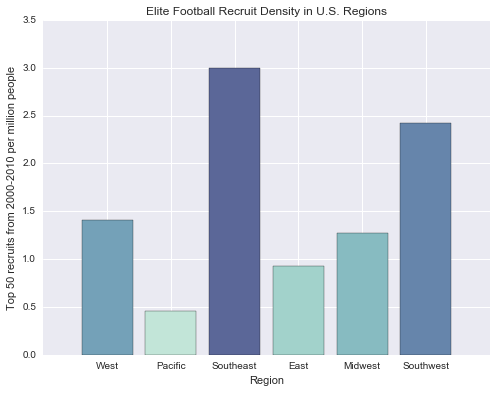

In [142]:
plt.figure(figsize=(8,6))
plt.bar(range(1, len(region_density)+1), region_density.values(), 
        color=[state_colors[3], state_colors[0], state_colors[5], state_colors[1], state_colors[2], state_colors[4]],
        align='center',
        tick_label=region_density.keys())
plt.xlabel("Region")
plt.ylabel('Top 50 recruits from 2000-2010 per million people')
plt.title('Elite Football Recruit Density in U.S. Regions');

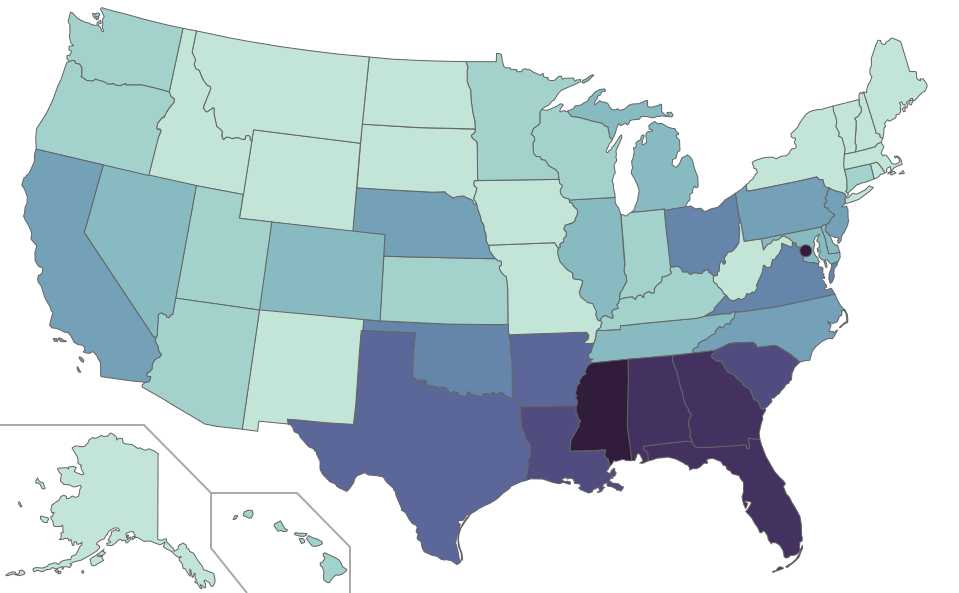

In [143]:
display(SVG('recruit_density_map.svg'));

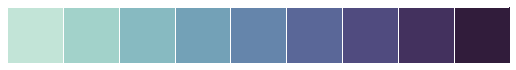

In [144]:
sns.palplot(sns.cubehelix_palette(9, start=0.5, rot=-0.5))

Could it be possible, though, that these high profile recruits from the Southeast are also superior to their contemporaries from other regions of the US?

In [145]:
df = pd.read_pickle('recruit_data.pkl')

In [146]:
region_list = ["West", "Midwest", "East", "Southeast", "Southwest"] # Pacific witheld due to low sample size
segments = [(1, 10), (11, 20), (21, 30), (31, 40), (41, 50)]

In [147]:
# get proportion drafted for each region/ranking bin
draft_results = {}
for region in region_list:
    draft_results[region] = []
    for low, high in segments:
        draft_results[region].append(df[(df.region == region) & (df['rank'] >= low) & (df['rank'] <= high)].drafted.mean())

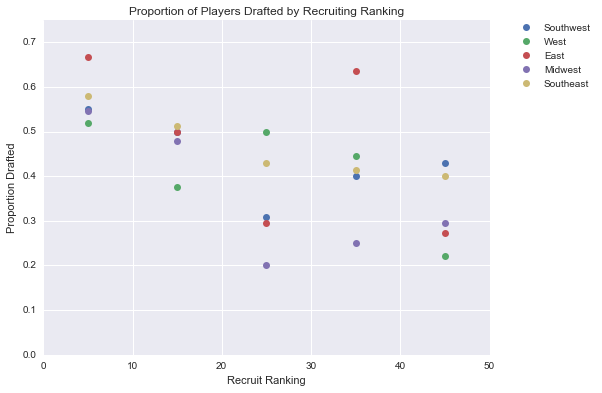

In [148]:
plt.figure(figsize=(8,6))
x_axis = [5, 15, 25, 35, 45]
plt.xlim(0, 50)
plt.ylim(0, 0.75)
plt.title('Proportion of Players Drafted by Recruiting Ranking')
plt.xlabel('Recruit Ranking')
plt.ylabel('Proportion Drafted')
for region in draft_results:
    plt.plot(x_axis, draft_results[region], 'o')
plt.legend(draft_results.keys(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [149]:
# get average draft pick for each region/ranking bin
draft_results = {}
for region in region_list:
    draft_results[region] = []
    for low, high in segments:
        draft_results[region].append(df[(df.region == region) & (df['rank'] >= low) & 
                                        (df['rank'] <= high) & df.drafted == 1].draft_pick.mean())            

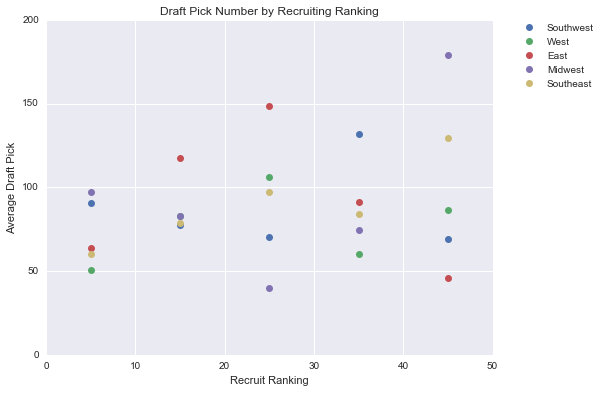

In [150]:
plt.figure(figsize=(8,6))
x_axis = [5, 15, 25, 35, 45]
plt.xlim(0, 50)
plt.ylim(0, 200)
plt.title('Draft Pick Number by Recruiting Ranking')
plt.xlabel('Recruit Ranking')
plt.ylabel('Average Draft Pick')
for region in draft_results:
    plt.plot(x_axis, draft_results[region], 'o')
plt.legend(draft_results.keys(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [152]:
df.to_csv('recruit_data.csv') # write data to csv